# Dependence of time step

This script analyses how the error for different values of $1/H$ depends on the time step parameter $\tau$. The reference solution is evaluated with a time step parameter $\tau = 0.0001$ on a fine mesh with $1/h = 256$. For the coarse solution, the evaluation is done for $\tau = 0.1, 0.01, 0.001, 0.0001$, and the final time is set to $T=0.2$. 

In [ ]:
import numpy as np
import scipy.sparse as sparse
from gridlod import util, fem, coef, interp, linalg, pg
from gridlod.world import World
import lod_wave
import matplotlib.pyplot as plt

'''
Settings
'''

# fine mesh parameters
fine = 256
NFine = np.array([fine])
NpFine = np.prod(NFine + 1)
boundaryConditions = np.array([[0, 0]])
world = World(np.array([256]), NFine / np.array([256]), boundaryConditions)
NWorldFine = world.NWorldCoarse * world.NCoarseElement

# fine grid elements and nodes
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

# ms coefficients
epsA = 2 ** (-4)
epsB = 2 ** (-6)
aFine = (2 - np.sin(2 * np.pi * xt / epsA)) ** (-1)
bFine = (2 - np.cos(2 * np.pi * xt / epsB)) ** (-1)

# compute ms matrices
S = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, aFine)
K = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, bFine)
M = fem.assemblePatchMatrix(NWorldFine, world.MLocFine)

'''
Compute exact solution
'''

# exact solution
UFine = [np.zeros_like(xp)]
UFine.append(np.zeros_like(xp))

# fine free indices
boundaryMap = boundaryConditions == 0
fixedFine = util.boundarypIndexMap(NWorldFine, boundaryMap)
freeFine = np.setdiff1d(np.arange(NpFine), fixedFine)

SFree = S[freeFine][:, freeFine]
KFree = K[freeFine][:, freeFine]

f = np.ones(NpFine)
LFineFull = M * f
LFineFree = LFineFull[freeFine]

tau = 0.0001
final_time = 0.2
numTimeSteps = int(final_time / tau)

for i in range(numTimeSteps):
    n = i + 1

    # reference system
    A = (1. / tau) * SFree + KFree
    b = LFineFree + (1. / tau) * SFree * UFine[n][freeFine]

    # solve system
    UFineFree = linalg.linSolve(A, b)
    UFineFull = np.zeros(NpFine)
    UFineFull[freeFine] = UFineFree

    # append solution
    UFine.append(UFineFull)

# time step parameters
tau_list = [0.1, 0.01, 0.001, 0.0001]
final_time = 0.2

# mesh and localization parameters
k = np.inf
NList = [2, 4, 8, 16, 32, 64]

error = []
solutions = []

for tau in tau_list:

    numTimeSteps = int(final_time / tau)
    tau_error = []

    for N in NList:

        # coarse mesh parameters
        NWorldCoarse = np.array([N])
        NCoarseElement = NFine / NWorldCoarse
        world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

        # grid nodes
        xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
        NpCoarse = np.prod(NWorldCoarse + 1)

        '''
        Compute multiscale basis
        '''

        # patch generator and coefficients
        IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                                      NCoarseElement, boundaryConditions)
        b_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, bFine)
        a_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, aFine / tau)

        # compute basis correctors
        lod = lod_wave.LodWave(b_coef, world, k, IPatchGenerator, a_coef)
        lod.compute_basis_correctors()

        # compute ms basis
        basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
        basis_correctors = lod.assembleBasisCorrectors()
        ms_basis = basis - basis_correctors

        '''
        Compute finescale system
    
        fs_solutions[i] = {w^i_x}_x
        '''

        prev_fs_sol = ms_basis
        fs_solutions = []
        for i in xrange(numTimeSteps):

            # solve non-localized system
            lod = lod_wave.LodWave(b_coef, world, np.inf, IPatchGenerator, a_coef, prev_fs_sol, ms_basis)
            lod.solve_fs_system()

            # store sparse solution
            prev_fs_sol = sparse.csc_matrix(np.array(np.column_stack(lod.fs_list)))
            fs_solutions.append(prev_fs_sol)

        '''
        Compute v^n and w^n
        '''

        # initial value
        Uo = np.zeros_like(xpCoarse)

        # coarse v^(-1) and v^0
        V = [Uo]
        V.append(Uo)

        # fine v^(-1) and v^0
        VFine = [ms_basis * Uo]
        VFine.append(ms_basis * Uo)

        # initial value w^0
        Wo = np.zeros(NpFine)
        WFine = [Wo]

        SmsFull = ms_basis.T * S * ms_basis
        KmsFull = ms_basis.T * K * ms_basis

        free = util.interiorpIndexMap(NWorldCoarse)

        SmsFree = SmsFull[free][:, free]
        KmsFree = KmsFull[free][:, free]

        # load vector
        f = np.ones(NpFine)
        LFull = M * f
        LmsFull = ms_basis.T * LFull
        LmsFree = LmsFull[free]

        RmsFreeList = []
        for i in xrange(numTimeSteps):
            n = i + 1

            # linear system
            A = (1. / tau) * SmsFree + KmsFree
            b = LmsFree + (1. / tau) * SmsFree * V[n][free]

            # store ms matrix R^{ms',h}_{H,i,k}
            RmsFull = ms_basis.T * S * fs_solutions[i]
            RmsFree = RmsFull[free][:, free]
            RmsFreeList.append(RmsFree)

            # add sum to linear system
            if i is not 0:
                for j in range(i):
                    b += (1. / tau) * RmsFreeList[j] * V[n - 1 - j][free]

            # solve system
            VFree = linalg.linSolve(A, b)
            VFull = np.zeros(NpCoarse)
            VFull[free] = VFree

            # append solution for current time step
            V.append(VFull)
            VFine.append(ms_basis * VFull)

            # evaluate w^n
            w = 0
            if i is not 0:
                for j in range(0, i + 1):
                    w += fs_solutions[j] * V[n - j]
            WFine.append(w)

        tau_error.append(np.sqrt(np.dot((UFine[-1] - VFine[-1] - WFine[-1]), (UFine[-1] - VFine[-1] - WFine[-1]))))

    error.append(tau_error)

# Plot the error

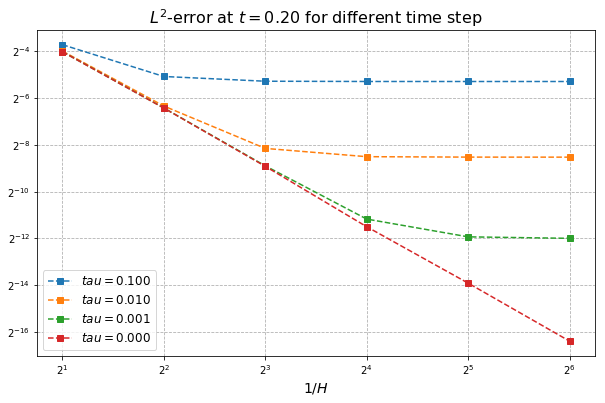

In [4]:
# plot errors
plt.figure('Error comparison', figsize=(10,6))
for i in range(len(tau_list)):
    plt.loglog(NList, error[i], '--s', basex=2, basey=2, label='$tau=%.3f$' %tau_list[i])
plt.grid(True, which="both", ls="--")
plt.xlabel('$1/H$', fontsize=14)
plt.title('$L^2$-error at $t=%.2f$ for different time step' % (numTimeSteps * tau), fontsize=16)
plt.legend(fontsize=12)

plt.show()